In [90]:
import torch
import polars as pl 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

%load_ext autoreload
%autoreload 2

if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device('cuda')
else:
    print("Using CPU")
    device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using CUDA


In [91]:
# data_df = pl.read_csv("data/google_stock_price_train_standardized.csv")
data_df = pl.read_csv("data/google_stock_price_train_yfinance.csv")

data_df

Close,High,Low,Open,Volume,Date
f64,f64,f64,f64,f64,str
-1.604091,-1.602328,-1.608212,-1.60523,4.281968,"""2004-08-19"""
-1.582314,-1.588694,-1.595726,-1.602471,1.698872,"""2004-08-20"""
-1.579336,-1.576745,-1.572211,-1.575869,1.157011,"""2004-08-23"""
-1.591713,-1.58185,-1.587282,-1.574531,0.800902,"""2004-08-24"""
-1.588626,-1.591627,-1.58643,-1.591683,0.083813,"""2004-08-25"""
…,…,…,…,…,…
2.504705,2.514772,2.524529,2.542764,-0.809622,"""2016-10-26"""
2.484301,2.495744,2.497916,2.513484,-0.67987,"""2016-10-27"""
2.484411,2.561169,2.509456,2.553784,-0.500737,"""2016-10-28"""


In [92]:
from scipy.signal import argrelextrema
import numpy as np

# create col of zeros for now
minimas = pl.Series("minimas", [0] * len(data_df))
minima_indices = argrelextrema(data_df['Close'].to_numpy(), np.less, order=20)[0]
print(minima_indices)
minimas[minima_indices] = 1

# RSI
window_rsi = 14
delta = data_df["Close"].diff().alias("delta")

gain = delta.clip(lower_bound=0)
loss = -delta.clip(upper_bound=0)

avg_gain = gain.rolling_mean(window_size=window_rsi, min_periods=1)
avg_loss = loss.rolling_mean(window_size=window_rsi, min_periods=1)

rs = avg_gain / avg_loss

# MACD
short_span = 12
long_span = 26
signal_span = 9

macd = data_df["Close"].ewm_mean(span=short_span, adjust=False) - data_df[ "Close" ].ewm_mean(span=long_span, adjust=False)
signal = macd.ewm_mean(span=signal_span, adjust=False)

# Bollinger Bands
window_bollinger = 20
mid = data_df['Close'].rolling_mean(window_size=window_bollinger)
upper = mid + 2 * data_df['Close'].rolling_std(window_size=window_bollinger)
lower = mid - 2 * data_df['Close'].rolling_std(window_size=window_bollinger)

# 3 day price difference
return_days = 14
returns = data_df['Close'].alias("3_day_price_diff") - data_df['Close'].shift(-return_days)
print(returns)
print(returns.min())
print(returns.max())
print(returns.mean())
print(returns.std())

data_df = data_df.with_columns(
    pl.col("Close").rolling_mean(20).alias("sma_20"),
    rs / (1 + rs).alias("rsi") / 100,
    macd.alias("MACD"),
    signal.alias("Signal"),
    upper.alias("Upper"),
    lower.alias("Lower"),
    pl.col('Date').str.to_datetime().dt.weekday().alias("Day") / 7,
    pl.col('Date').str.to_datetime().dt.month().alias("Month") / 12,
    minimas,
    returns
)

data_df

[  11   66  109  142  254  292  393  441  492  592  637  688  753  819
  894  996 1043 1075 1112 1145 1228 1389 1449 1479 1519 1582 1655 1725
 1764 1794 1832 1873 1903 1932 1970 2077 2180 2274 2300 2375 2445 2512
 2559 2617 2683 2739 2773 2796 2888 2943 2984 3036]
shape: (3_074,)
Series: '3_day_price_diff' [f64]
[
	-0.005383
	0.008142
	0.005191
	-0.018088
	-0.016394
	…
	null
	null
	null
	null
	null
]
-0.7777282517741538
0.43276786505236453
-0.018614654919754052
0.12216174636145788


Close,High,Low,Open,Volume,Date,sma_20,delta,MACD,Signal,Upper,Lower,Day,Month,minimas,3_day_price_diff
f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64
-1.604091,-1.602328,-1.608212,-1.60523,4.281968,"""2004-08-19""",null,null,0.0,0.0,null,null,0.571429,0.666667,0,-0.005383
-1.582314,-1.588694,-1.595726,-1.602471,1.698872,"""2004-08-20""",null,NaN,0.001737,0.000347,null,null,0.714286,0.666667,0,0.008142
-1.579336,-1.576745,-1.572211,-1.575869,1.157011,"""2004-08-23""",null,NaN,0.003316,0.000941,null,null,0.142857,0.666667,0,0.005191
-1.591713,-1.58185,-1.587282,-1.574531,0.800902,"""2004-08-24""",null,0.006667,0.003528,0.001458,null,null,0.285714,0.666667,0,-0.018088
-1.588626,-1.591627,-1.58643,-1.591683,0.083813,"""2004-08-25""",null,0.006923,0.0039,0.001947,null,null,0.428571,0.666667,0,-0.016394
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2.504705,2.514772,2.524529,2.542764,-0.809622,"""2016-10-26""",2.436987,0.006313,0.043734,0.033092,2.572851,2.301123,0.428571,0.833333,0,null
2.484301,2.495744,2.497916,2.513484,-0.67987,"""2016-10-27""",2.442565,0.006172,0.04046,0.034566,2.576469,2.308661,0.571429,0.833333,0,null
2.484411,2.561169,2.509456,2.553784,-0.500737,"""2016-10-28""",2.447524,0.005623,0.037442,0.035141,2.579825,2.315223,0.714286,0.833333,0,null


In [93]:
# split into train and validation
idx = int(len(data_df) * 0.8)
train_df = data_df.slice(0, idx)
val_df = data_df.slice(idx)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 2459
Validation size: 615


In [94]:
train_input = (
    torch.tensor(train_df.drop("Date", "minimas", '3_day_price_diff').rows()[26:-return_days], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
train_output = (
    torch.tensor(train_df["3_day_price_diff"][26:], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
print(train_input.shape)
print(train_output.shape)

val_input = (
    torch.tensor(val_df.drop("Date", "minimas", '3_day_price_diff').rows()[26:-return_days], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
val_output = (
    torch.tensor(val_df["3_day_price_diff"][26:-return_days], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
print(val_input.shape)  
print(val_output.shape)

torch.Size([1, 2419, 13])
torch.Size([1, 2433])
torch.Size([1, 575, 13])
torch.Size([1, 575])


In [95]:
from torch.utils.data import Dataset, DataLoader


class StockDataset(Dataset):
    def __init__(self, input_tensor, output_tensor, window_steps=30):
        self.input_tensor = input_tensor
        self.output_tensor = output_tensor
        self.window_steps = window_steps

    def __len__(self):
        return self.input_tensor.shape[0] - self.window_steps

    def __getitem__(self, idx):
        return self.input_tensor[idx : idx + self.window_steps], self.output_tensor[
            idx + self.window_steps
        ].unsqueeze(0)


train_dataset = StockDataset(train_input.squeeze(), train_output.squeeze(), window_steps=30)
print(len(train_dataset))
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)
print(train_dataset[1][1])

val_dataset = StockDataset(val_input.squeeze(), val_output.squeeze(), window_steps=30)
print(len(val_dataset))


2389
torch.Size([30, 13])
torch.Size([1])
tensor([-0.0363], device='cuda:0')
545


In [96]:
from torch import dropout, nn
import random


class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, **kwargs):
        super(SimpleLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers, batch_first=True, **kwargs
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, state=None):
        if state is None:
            h0 = torch.ones(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            c0 = torch.ones(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            state = (h0, c0)
        out, h = self.rnn(x, state)
        out = self.fc(out)
        return out, h


class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size, hidden_size, num_layers=num_layers, batch_first=True
        )
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
        out, h = self.rnn(x, h0)
        out = self.dropout(self.fc1(out))
        return out, h


class LSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, **kwargs):
        super(LSTM2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers, batch_first=True, **kwargs
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, state=None):
        if state is None:
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            state = (h0, c0)
        _, h = self.rnn(x, state)
        out = self.fc(h)
        return out, h


In [97]:
from utils.early_stopping import EarlyStopping
from utils.training import Trainer


rnn2 = SimpleLSTM(13, 50, 1, 2, dropout=0.5).to(device)
# criterion = FocalLossRegression(gamma=2, alpha=1.0)
# criterion = AsymmetricLoss(alpha=1.0, beta=5.0)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn2.parameters(), lr=0.00001, weight_decay=1e-5)
early_stop = EarlyStopping(patience=50, verbose=True, path="checkpoints/rnn2.pt")

# encoder_input = torch.randn(32, 30, 5).to(device)
# decoder_input = torch.randn(32, 5, 5).to(device)
# output = rnn2(encoder_input, decoder_input)

# print(output.shape)

# encoder_input = torch.randn(1, 30, 5).to(device)
# decoder_input = torch.zeros(1, 1, 5).to(device)
# output = rnn2(encoder_input, None, target_length=5)

# print(output.shape)

trainer = Trainer(
    "test",
    rnn2,
    DataLoader(train_dataset, batch_size=16, shuffle=True),
    DataLoader(val_dataset, batch_size=16),
    optimizer,
    criterion,
    early_stop,
)

In [98]:
trainer.fit(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Validation loss decreased (inf --> 1.241903).  Saving model ...
Epoch [1/2000]  LR: 0.00001  T_Loss: 0.0157   V_Loss: 1.2419
Validation loss decreased (1.241903 --> 1.205957).  Saving model ...
Epoch [2/2000]  LR: 0.00001  T_Loss: 0.0130   V_Loss: 1.2060
Validation loss decreased (1.205957 --> 1.179727).  Saving model ...
Epoch [3/2000]  LR: 0.00001  T_Loss: 0.0121   V_Loss: 1.1797
Validation loss decreased (1.179727 --> 1.157538).  Saving model ...
Epoch [4/2000]  LR: 0.00001  T_Loss: 0.0117   V_Loss: 1.1575
Validation loss decreased (1.157538 --> 1.144359).  Saving model ...
Epoch [5/2000]  LR: 0.00001  T_Loss: 0.0116   V_Loss: 1.1444
Validation loss decreased (1.144359 --> 1.136142).  Saving model ...
Epoch [6/2000]  LR: 0.00001  T_Loss: 0.0114   V_Loss: 1.1361
Validation loss decreased (1.136142 --> 1.128915).  Saving model ...
Epoch [7/2000]  LR: 0.00001  T_Loss: 0.0114   V_Loss: 1.1289
Validation loss decreased (1.128915 --> 1.124879).  Saving model ...
Epoch [8/2000]  LR: 0.0000

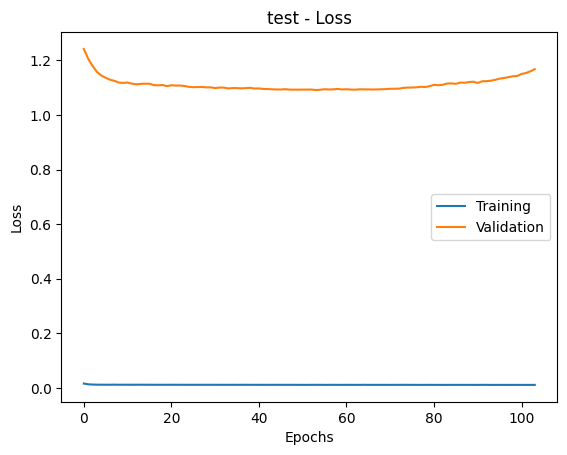

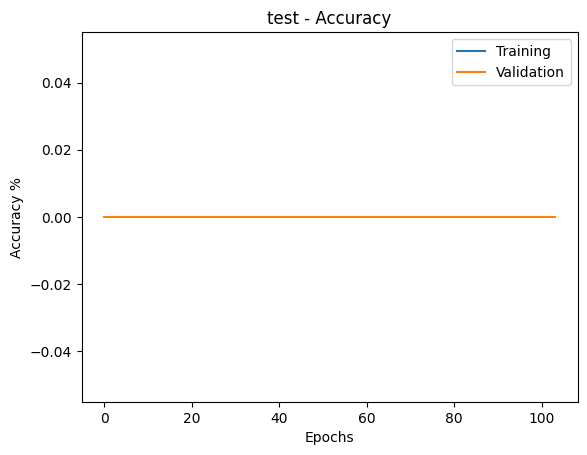

In [99]:
trainer.plot()

In [102]:
val_minima_points = val_df.filter(val_df["minimas"] == 1)

all_inputs, _, all_predictions = trainer.infer(DataLoader(val_dataset, batch_size=128))


# Plot close prices and minima
fig = go.Figure()

x = list(range(len(val_input.squeeze())))

norm_all_predictions = (all_predictions - all_predictions.min()) / (
    all_predictions.max() - all_predictions.min()
)

standardise_all_predictions = (all_predictions - all_predictions.mean()) / all_predictions.std()

print(norm_all_predictions)

fig.add_trace(
    go.Scatter(
        x=list(range(30, 30 + len(all_predictions))),
        y=standardise_all_predictions.squeeze(),
        mode="lines",
        name="Predicted Minimas",
    )
)

# Line plot for Close prices
print(val_input.squeeze().cpu()[:, 0])

fig.add_trace(
    go.Scatter(
        x=x,
        y=val_input.squeeze().cpu()[:, 0],
        mode="lines",
        name="Close",
        line=dict(color="black"),
    )
)


# Create segments for the line
segments_x = []
segments_y = []
segments_colors = []

y = val_input.cpu()[0]
for i in range(30, 30 + len(all_predictions) - 1):
    segments_x.append([x[i], x[i + 1], None])  # None breaks the line
    segments_y.append([y[i], y[i + 1], None])
    segments_colors.append(
        norm_all_predictions[i - 30][0].item()
    )  # Use start point for color

fig.add_trace(
    go.Scatter(
        x=list(range(30, 30 + len(all_predictions))),
        y=val_input.squeeze().cpu()[30:, 0],
        mode="markers",
        name="Predicted Minimas",
        marker=dict(
            color=segments_colors,
            colorscale="Rainbow",
            cmin=0,
            cmax=1,
        ),
    )
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(val_input))),
        y=all_predictions.squeeze(),
        mode="markers",
        name="Predicted Minimas",
        marker=dict(
            color=segments_colors,
            colorscale="Rainbow",
            cmin=0,
            cmax=1,
        ),
    )
)

# 14 day returns
fig.add_trace(
    go.Scatter(
        x=list(range(30, 30 + len(all_predictions))),
        y=val_df["3_day_price_diff"][30:-14],
        mode="lines",
        name="14 Day Returns",
    )
)
print(val_df["3_day_price_diff"][30:-14].max())

fig.update_layout(
    title="Close Prices and Minimas",
    xaxis_title="Date",
    yaxis_title="Price",
    showlegend=True,
)

fig.show()


[[0.23552229]
 [0.24549757]
 [0.23679213]
 [0.2235543 ]
 [0.2163035 ]
 [0.21548079]
 [0.21933194]
 [0.21156855]
 [0.20537484]
 [0.20710021]
 [0.21305567]
 [0.22353193]
 [0.21964379]
 [0.21033634]
 [0.20679638]
 [0.21269113]
 [0.20238402]
 [0.18900593]
 [0.18050613]
 [0.1821262 ]
 [0.19377217]
 [0.19077617]
 [0.18446118]
 [0.18626551]
 [0.19378097]
 [0.22387215]
 [0.22389908]
 [0.21287294]
 [0.20814474]
 [0.2128342 ]
 [0.2200704 ]
 [0.20979856]
 [0.20116174]
 [0.19286884]
 [0.18710585]
 [0.18726072]
 [0.17331088]
 [0.16247073]
 [0.16084613]
 [0.1722614 ]
 [0.19159535]
 [0.19226055]
 [0.18632166]
 [0.19863647]
 [0.21896443]
 [0.25758347]
 [0.2579605 ]
 [0.2457834 ]
 [0.23932621]
 [0.23512687]
 [0.23175801]
 [0.2038031 ]
 [0.17307794]
 [0.1547881 ]
 [0.14422667]
 [0.14633961]
 [0.12436125]
 [0.09605967]
 [0.08110317]
 [0.07152303]
 [0.07218921]
 [0.05629712]
 [0.03831021]
 [0.03008747]
 [0.03279775]
 [0.04321527]
 [0.04296842]
 [0.04290255]
 [0.04570052]
 [0.05534011]
 [0.07584917]
 [0.07

/home/caleb/personal/uni/dlp/a3-rnn-stock-prediction/utils/training.py:188: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/home/caleb/personal/uni/dlp/a3-rnn-stock-predictio